## Imports

In [1]:
import functools

from collections.abc import Callable, Sequence

from clu import metric_writers
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import optax
import orbax.checkpoint as ocp

import h5py
import natsort
import tensorflow as tf
from scipy.ndimage import geometric_transform
from scipy.ndimage import gaussian_filter

from swirl_dynamics import templates
from swirl_dynamics.lib import diffusion as dfn_lib
from swirl_dynamics import lib
from swirl_dynamics.lib import solvers as solver_lib
from swirl_dynamics.projects import probabilistic_diffusion as dfn

2024-03-30 09:44:38.760816: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Conditional diffusion model with WideBNet

In [2]:
Array = jax.Array
Initializer = nn.initializers.Initializer

def default_init(scale: float = 1e-10) -> Initializer:
  return nn.initializers.variance_scaling(
      scale=scale, mode="fan_avg", distribution="uniform"
  )

In [3]:
def morton_to_flatten_indices(L, s, b_flatten=True):
    """ Permutes a morton-flattened vector to python-flattened vector,
    e.g.
        >> ind = morton_to_flatten_indices(L, s)
        >> X.flatten() == morton_flatten(X, L, s)[ind]
    """
    if L==0:
        return np.arange(s**2).reshape(s,s)
    else:
        blk = 4**(L-1)*s*s

        tmp = morton_to_flatten_indices(L-1,s, b_flatten=False)

        tmp1 = np.hstack((tmp, blk+tmp))
        tmp2 = np.hstack((2*blk+tmp, 3*blk+tmp))

        if b_flatten:
            return np.vstack((tmp1,tmp2)).flatten()
        else:
            return np.vstack((tmp1,tmp2))

def flatten_to_morton_indices(L, s):
    """ Permutes a python-flattened vector to morton-flattened vector,
    e.g.
        >> X = np.random.randn((2**L)*s, (2**L)*s)
        >> idx = flatten_to_morton_indices(L,s)
        >> X.flatten()[idx] == morton_flatten(X, L, s)
    """
    nx =  (2**L)*s
    X = np.arange(nx*nx).reshape(nx, nx)
    return morton_flatten(X, L, s)

def morton_flatten(x, L, s):
    """ Flatten via Z-ordering a (2^L)s by (2^L)s dimensional matrix. 
    """
    assert x.shape[0] == (2**L)*s
    assert x.shape[1] == (2**L)*s

    if L == 0:
        return x.flatten()
    else:
        blk = 2**(L-1)*s
        return np.hstack((morton_flatten(x[0:blk, 0:blk], L-1,s),
            morton_flatten(x[0:blk, blk:(2*blk)], L-1,s),
            morton_flatten(x[blk:(2*blk), 0:blk], L-1,s),
            morton_flatten(x[blk:(2*blk), blk:(2*blk)], L-1,s)))

def morton_reshape(x, L, s):
    """ Reassembles morton flattened vector into matrix.
    """
    assert x.shape[0] == (4**L)*s*s

    if L == 0:
        return x.reshape(s,s)
    else:
        blk = 4**(L-1)*s*s

        tmp1 = np.hstack((morton_reshape(x[0:blk], L-1, s),
                morton_reshape(x[blk:(2*blk)], L-1, s)))

        tmp2 = np.hstack((morton_reshape(x[(2*blk):(3*blk)], L-1, s),
                morton_reshape(x[(3*blk):(4*blk)], L-1, s)))

        return np.vstack((tmp1, tmp2))

### Dataset

In [4]:
# Parameters for the computational task.

L = 4 # number of levels (even number)
s = 5 # leaf size
r = 3 # rank

# Discretization of Omega (n_eta * n_eta).
neta = (2**L)*s


idx_flatten_to_morton = flatten_to_morton_indices(L, s)
idx_morton_to_flatten = morton_to_flatten_indices(L, s)

# Number of sources/detectors (n_sc).
# Discretization of the domain of alpha in polar coordinates (n_theta * n_rho).
# For simplicity, these values are set equal (n_sc = n_theta = n_rho), facilitating computation.
nx = (2**L)*s

# Standard deviation for the Gaussian blur.
blur_sigma = 0.5

# Batch size.
BATCH_SIZE = 16

# Number of training datapoints.
#NTRAIN = 18000

# Number of testing datapoints.
#NTEST = 2000

# Total number
NTRAIN = 18000

In [5]:
#name = 'Data/traindata_smooth_sigma_0.04'
#name = 'Data/traindata_shepp_logan'
name = 'Data/traindata_L4s5_multifreq_ns10_square_10h_freq_2.5_5_10'
#name = 'Data/traindata_3510tri'
#name = 'Data/traindata_L4s5_multifreq_tri_10h_freq_2.5_5_10' # bad
#name = 'Data/traindata_L4s5_multifreq_gaussian_10h_freq_2.5_5_10' #up to 14000 samples only # bad
#name = 'Data/traindata_L4s5_multifreq_blob_freq_2.5_5_10' # bad
#name = 'Data/traindata_L4s5_multifreq_tri_5h_freq_2.5_5_10' # bad
#name = 'Data/traindata_L4s5_multifreq_square_10h_freq_2.5_5_10' # bad
#name = 'Data/traindata_smooth_sigma_0.01' # bad


# Loading and preprocessing perturbation data (eta)
with h5py.File(f'{name}/eta.h5', 'r') as f:
    # Read eta data, apply Gaussian blur, and reshape
    eta_re = f[list(f.keys())[0]][:NTRAIN, :].reshape(-1, neta, neta)
    blur_fn = lambda x: gaussian_filter(x, sigma=blur_sigma)
    eta_re = np.stack([blur_fn(eta_re[i, :, :]) for i in range(NTRAIN)]).astype('float32')

# Loading and preprocessing scatter data (Lambda)
with h5py.File(f'{name}/scatter.h5', 'r') as f:
    keys = natsort.natsorted(f.keys())

    # Process real part of scatter data
    tmp1 = f[keys[3]][:NTRAIN, :].reshape((-1, nx, nx))
    tmp2 = f[keys[4]][:NTRAIN, :].reshape((-1, nx, nx))
    tmp3 = f[keys[5]][:NTRAIN, :].reshape((-1, nx, nx))
    scatter_re = np.stack((tmp1, tmp2, tmp3), axis=-1)
    #scatter_re = np.stack((tmp2, tmp3), axis=-1)
    #scatter_re = tmp1
    
    # Process imaginary part of scatter data
    tmp1 = f[keys[0]][:NTRAIN, :].reshape((-1, nx, nx))
    tmp2 = f[keys[1]][:NTRAIN, :].reshape((-1, nx, nx))
    tmp3 = f[keys[2]][:NTRAIN, :].reshape((-1, nx, nx))
    scatter_im = np.stack((tmp1, tmp2, tmp3), axis=-1)
    #scatter_im = np.stack((tmp2, tmp3), axis=-1)
    #scatter_im = tmp1

    # Combine real and imaginary parts
    scatter_ = np.stack((scatter_re, scatter_im), axis=1).astype('float32')

# Clean up temporary variables to free memory
del scatter_re, scatter_im, tmp1, tmp2, tmp3

In [6]:
scatter = np.swapaxes(np.swapaxes(np.swapaxes(scatter_,1,2),2,3),3,4)
#scatter = np.swapaxes(np.swapaxes(scatter_,1,2),2,3)
assert scatter.shape == (NTRAIN, 80, 80, 3, 2)
#assert scatter.shape == (NTOTAL, 80, 80, 2, 2)
#assert scatter.shape == (NTRAIN, 80, 80, 2)

In [7]:
scatter_train = np.reshape(scatter[:,:,:],(NTRAIN,80,80,6))
eta_re_train = np.array([eta_re[:,:,:]])
eta_re_train = np.swapaxes(np.swapaxes(np.swapaxes(eta_re_train,0,1),1,2),2,3)
#scatter_eta_re = np.concatenate((scatter,eta_re),axis=-1)
assert eta_re_train.shape == (NTRAIN, 80, 80, 1)
assert scatter_train.shape == (NTRAIN, 80, 80, 6)
#assert scatter_train.shape == (NTRAIN, 80, 80, 4)
#assert scatter_train.shape == (NTRAIN, 80, 80, 2)

In [8]:
scatter_train_norm = scatter_train - np.mean(scatter_train,axis=0)#/(np.std(scatter,axis=0)+ 1e-4)
eta_re_train_norm = eta_re_train- np.mean(eta_re_train,axis=0)#/(np.std(eta_re,axis=0)+ 1e-4)
assert eta_re_train_norm.shape == (NTRAIN, 80, 80, 1)
assert scatter_train_norm.shape == (NTRAIN, 80, 80, 6)

In [9]:
# To avoid tf to use GPU memory
tf.config.set_visible_devices([], device_type='GPU')

batch_size = 16
dict_data = {"x": eta_re_train_norm}
dict_data["cond"] = {"channel:scatter": scatter_train_norm}
dataset = tf.data.Dataset.from_tensor_slices(dict_data)
dataset = dataset.repeat()
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(tf.data.AUTOTUNE)
dataset = eval_dataloader = dataset.as_numpy_iterator()

2024-03-30 09:45:11.175838: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
data_std = np.std(eta_re_train_norm)

In [11]:
print(data_std)

0.10550104


### Architecture

In [12]:
def build_permutation_indices(L, l):
    """ Returns dictionary of permutation indices at level 'l'.
    Ht_l = blkdiag(l) × column_permutation
    """
    # indices inside each 4^(L-l) × 4^(L-l) block
    delta = 4**(L-l-1)

    # [0, Δ, 2Δ, 3Δ, 0, Δ, 2Δ, 3Δ, 0, Δ, 2Δ, 3Δ, … ] 
    tmp = np.tile(np.arange(4)*delta, delta)

    # + [0, 0, 0, 0, 1, 1, 1, 1, … , Δ, Δ, Δ, Δ]
    tmp += np.repeat(np.arange(delta), 4)

    # indices for the entire block diagonal matrix
    tmp = np.tile(tmp, 4**l)
    tmp += np.repeat(np.arange(4**l)*(4**(L-l)), 4**(L-l))

    return jnp.asarray(tmp)

def build_switch_indices(L):
    """ Returns permutation indices for patches at the switch layer. 
    """
    tmp = np.arange(2**L)*(2**L)

    tmp = np.tile(tmp, 2**L)
    tmp += np.repeat(np.arange(2**L), 2**L)

    return jnp.asarray(tmp)

class V(nn.Module):
    r: int
    
    @nn.compact
    def __call__(self, x):
        n, s = x.shape[-2], x.shape[-1]

        init_fn = nn.initializers.glorot_uniform()
        vr1 = self.param('vr1', init_fn, (n, s, self.r))
        vi1 = self.param('vi1', init_fn, (n, s, self.r))
        vr2 = self.param('vr2', init_fn, (n, s, self.r))
        vi2 = self.param('vi2', init_fn, (n, s, self.r))

        x_re, x_im = x[:, 0, :, :], x[:, 1, :, :]
        y_re_1 = jnp.einsum('baj,ajk->bak', x_re, vr1)
        y_re_2 = jnp.einsum('baj,ajk->bak', x_im, vi1)
        y_re = y_re_1+y_re_2
        
        y_im_1 = jnp.einsum('baj,ajk->bak', x_re, vi2)
        y_im_2 = jnp.einsum('baj,ajk->bak', x_im, vr2)
        y_im = y_im_1+y_im_2
        
        y = jnp.stack([y_re, y_im], axis=1)
        
        return y

class H(nn.Module):
    L: int
    l: int

    def setup(self):
        self.perm_idx = build_permutation_indices(self.L, self.l)
        
    @nn.compact
    def __call__(self, x):
        m = x.shape[-2] // 4
        s = x.shape[-1] * 4

        # Define weights
        init_fn = nn.initializers.glorot_uniform()
        hr1 = self.param('hr1', init_fn, (m, s, s))
        hi1 = self.param('hi1', init_fn, (m, s, s))
        hr2 = self.param('hr2', init_fn, (m, s, s))
        hi2 = self.param('hi2', init_fn, (m, s, s))

        # Apply permutations
        x = x.take(self.perm_idx, axis=-2)
        
        # Reshape operation
        x = x.reshape((-1, 2, m, s))
        # Split real and imaginary parts for processing
        x_re, x_im = x[:, 0, :, :], x[:, 1, :, :]
        
        y_re_1 = jnp.einsum('baj,ajk->bak', x_re, hr1)
        y_re_2 = jnp.einsum('baj,ajk->bak', x_im, hi1)
        y_re = y_re_1+y_re_2
        
        y_im_1 = jnp.einsum('baj,ajk->bak', x_re, hi2)
        y_im_2 = jnp.einsum('baj,ajk->bak', x_im, hr2)
        y_im = y_im_1+y_im_2
        
        y = jnp.stack([y_re, y_im], axis=1)

        n = m * 4
        r = s // 4
        y = y.reshape((-1, 2, n, r))

        return y

class M(nn.Module):
    @nn.compact
    def __call__(self, x):
        n, s = x.shape[-2], x.shape[-1]

        init_fn = nn.initializers.glorot_uniform()
        mr1 = self.param('mr1', init_fn, (n, s, s))
        mi1 = self.param('mi1', init_fn, (n, s, s))
        mr2 = self.param('mr2', init_fn, (n, s, s))
        mi2 = self.param('mi2', init_fn, (n, s, s))

        x_re, x_im = x[:, 0, :, :], x[:, 1, :, :]

        y_re_1 = jnp.einsum('baj,ajk->bak', x_re, mr1)
        y_re_2 = jnp.einsum('baj,ajk->bak', x_im, mi1)
        y_re = y_re_1+y_re_2
        
        y_im_1 = jnp.einsum('baj,ajk->bak', x_re, mi2)
        y_im_2 = jnp.einsum('baj,ajk->bak', x_im, mr2)
        y_im = y_im_1+y_im_2
        
        y = jnp.stack([y_re, y_im], axis=1)
        
        return y

class G(nn.Module):
    L: int
    l: int

    def setup(self):
        self.perm_idx = build_permutation_indices(self.L, self.l)
        
    @nn.compact
    def __call__(self, x):
        m = x.shape[-2] // 4
        s = x.shape[-1] * 4
        t = s * (self.L - self.l + 1) // 3

        # Define weights
        init_fn = nn.initializers.glorot_uniform()
        gr1 = self.param('gr1', init_fn, (m, s, t))
        gi1 = self.param('gi1', init_fn, (m, s, t))
        gr2 = self.param('gr2', init_fn, (m, s, t))
        gi2 = self.param('gi2', init_fn, (m, s, t))        
        
        # Reshape operation
        x = x.reshape((-1, 2, m, s))
        # Split real and imaginary parts for processing
        x_re, x_im = x[:, 0, :, :], x[:, 1, :, :]
        
        y_re_1 = jnp.einsum('baj,ajk->bak', x_re, gr1)
        y_re_2 = jnp.einsum('baj,ajk->bak', x_im, gi1)
        y_re = y_re_1+y_re_2
        
        y_im_1 = jnp.einsum('baj,ajk->bak', x_re, gi2)
        y_im_2 = jnp.einsum('baj,ajk->bak', x_im, gr2)
        y_im = y_im_1+y_im_2
        
        y = jnp.stack([y_re, y_im], axis=1)

        n = m * 4
        r = t // 4
        y = y.reshape((-1, 2, n, r))
        
        y = y.take(self.perm_idx, axis=-2)
        
        return y


class U(nn.Module):
    s: int
    
    @nn.compact
    def __call__(self, x):
        n, r = x.shape[-2], x.shape[-1]

        init_fn = nn.initializers.glorot_uniform()
        ur1 = self.param('ur1', init_fn, (n, r, self.s))
        ui1 = self.param('ui1', init_fn, (n, r, self.s))
        ur2 = self.param('ur2', init_fn, (n, r, self.s))
        ui2 = self.param('ui2', init_fn, (n, r, self.s))

        x_re, x_im = x[:, 0, :, :], x[:, 1, :, :]

        y_re_1 = jnp.einsum('baj,ajk->bak', x_re, ur1)
        y_re_2 = jnp.einsum('baj,ajk->bak', x_im, ui1)
        y_re = y_re_1+y_re_2
        
        y_im_1 = jnp.einsum('baj,ajk->bak', x_re, ui2)
        y_im_2 = jnp.einsum('baj,ajk->bak', x_im, ur2)
        y_im = y_im_1+y_im_2
        
        y = jnp.stack([y_re, y_im], axis=1)
        
        return y

In [13]:
class WideBNetModel(nn.Module):
    L: int
    s: int
    r: int
    NUM_RESNET: int
    NUM_CNN: int
    idx_morton_to_flatten: jnp.ndarray
    
    def setup(self):
        self.nx = (2**self.L)*self.s
        self.switch_idx = build_switch_indices(self.L)
        self.convs = [nn.Conv(features=6, kernel_size=(2,2), padding='SAME') for _ in range(self.NUM_CNN-1)]
        self.final_conv = nn.Conv(features=1, kernel_size=(2,2), padding='SAME')
        
    @nn.compact
    def __call__(self, x, cond):
        out_spatial_shape = x.shape[-3:-1]
        for key, value in sorted(cond.items()):
            if key.startswith("channel:"):
                if value.ndim != x.ndim:
                    raise ValueError(
                        f"Channel condition `{key}` does not have the same ndim"
                        f" ({value.ndim}) as x ({x.ndim})!"
                    )
            if value.shape[-3:-1] != out_spatial_shape:
                y = value[..., 0]
                y = jnp.reshape(y, (-1, 2, 4**self.L, self.s**2))
                y = V(self.r)(y)
                
                for l in range(self.L-1, int(self.L/2)-1, -1):
                    d = self.L-l # layer depth in butterfly
                    y_l = value[..., d]
                    y_l = jnp.reshape(y_l, (-1, 2, 4**l, 4**d*self.s**2))
                    y_l = V(self.r)(y_l)
                    y_l = y_l.repeat(4**d, axis = -2)
                    y = jnp.concatenate([y, y_l], axis = -1)
                    y = H(self.L,l)(y)  
                y = y.take(self.switch_idx, axis=-2)
                for m in range(self.NUM_RESNET):
                    y_tmp = y + M()(nn.relu(M()(y)))
                    y = y + y_tmp
                    if not (m+1)==self.NUM_RESNET:
                        y = nn.relu(y)
                for l in range(self.L//2, self.L):
                    y = G(self.L,l)(y)
                
                y = U(self.s**2)(y)
                y = y[:, 0, ...]
                y = jnp.reshape(y, (-1, self.nx**2))
                y = y.take(self.idx_morton_to_flatten, axis = -1)
                
                y = jnp.reshape(y, (-1, self.nx, self.nx, 1))
                
                for conv_layer in self.convs:
                    y = conv_layer(y)
                    y = nn.relu(y)
                
                value = self.final_conv(y)
                
                value = value[:,:,:,0]
            x = jnp.concatenate([x, value], axis=-1)
        return x

In [14]:
class UNet_widebnet(nn.Module):
    """UNet model compatible with 1 or 2 spatial dimensions."""

    out_channels: int
    L: int
    s: int
    r: int
    NUM_RESNET: int
    NUM_CNN: int
    idx_morton_to_flatten: jnp.ndarray
    resize_to_shape: tuple[int, ...] | None = None  # spatial dims only
    num_channels: tuple[int, ...] = (128, 256, 256, 256)
    downsample_ratio: tuple[int, ...] = (2, 2, 2, 2)
    num_blocks: int = 4
    noise_embed_dim: int = 128
    padding: str = "CIRCULAR"
    dropout_rate: float = 0.0
    use_attention: bool = True  # lowest resolution only
    use_position_encoding: bool = True
    num_heads: int = 8
    cond_resize_method: str = "bilinear"
    cond_embed_dim: int = 128
    cond_merging_fn: nn.Module = WideBNetModel

    @nn.compact
    def __call__(
      self,
      x: Array,
      sigma: Array,
      cond: dict[str, Array] | None = None,
      *,
      is_training: bool,
    ) -> Array:
        """
        Predicts denoised given noised input and noise level.
        
        Args:
          x: The model input (i.e. noised sample) with shape `(batch,
            **spatial_dims, channels)`.
          sigma: The noise level, which either shares the same batch dimension as
            `x` or is a scalar (will be broadcasted accordingly).
          cond: The conditional inputs as a dictionary. Currently, only channelwise
            conditioning is supported.
          is_training: A boolean flag that indicates whether the module runs in
            training mode.
        
        Returns:
          An output array with the same dimension as `x`.
        """
        if sigma.ndim < 1:
          sigma = jnp.broadcast_to(sigma, (x.shape[0],))
        
        if sigma.ndim != 1 or x.shape[0] != sigma.shape[0]:
          raise ValueError(
              "sigma must be 1D and have the same leading (batch) dimension as x"
              f" ({x.shape[0]})!"
          )
        
        input_size = x.shape[1:-1]
        if self.resize_to_shape is not None:
          x = lib.layers.FilteredResize(
              output_size=self.resize_to_shape,
              kernel_size=(7, 7),
              padding=self.padding,
          )(x)
        
        kernel_dim = x.ndim - 2
        cond = {} if cond is None else cond
        x = self.cond_merging_fn(
            L=self.L, s=self.s, r=self.r,
            NUM_RESNET=self.NUM_RESNET, NUM_CNN=self.NUM_CNN,
            idx_morton_to_flatten=self.idx_morton_to_flatten,
        )(x, cond)
        
        emb = dfn_lib.unets.FourierEmbedding(dims=self.noise_embed_dim)(sigma)
        skips = dfn_lib.unets.DStack(
            num_channels=self.num_channels,
            num_res_blocks=len(self.num_channels) * (self.num_blocks,),
            downsample_ratio=self.downsample_ratio,
            padding=self.padding,
            dropout_rate=self.dropout_rate,
            use_attention=self.use_attention,
            num_heads=self.num_heads,
            use_position_encoding=self.use_position_encoding,
        )(x, emb, is_training=is_training)
        h = dfn_lib.unets.UStack(
            num_channels=self.num_channels[::-1],
            num_res_blocks=len(self.num_channels) * (self.num_blocks,),
            upsample_ratio=self.downsample_ratio[::-1],
            padding=self.padding,
            dropout_rate=self.dropout_rate,
            use_attention=self.use_attention,
            num_heads=self.num_heads,
        )(skips[-1], emb, skips, is_training=is_training)
        
        h = nn.swish(nn.GroupNorm(min(h.shape[-1] // 4, 32))(h))
        h = lib.layers.ConvLayer(
            features=self.out_channels,
            kernel_size=kernel_dim * (3,),
            padding=self.padding,
            kernel_init=default_init(),
            name="conv_out",
        )(h)
        
        if self.resize_to_shape:
          h = lib.layers.FilteredResize(
              output_size=input_size, kernel_size=(7, 7), padding=self.padding
          )(h)
        return h

In [15]:
class PreconditionedDenoiser_WideBNet(UNet_widebnet):
  """Preconditioned denoising model.

  See Appendix B.6 in Karras et al. (https://arxiv.org/abs/2206.00364).
  """

  sigma_data: float = 1.0

  @nn.compact
  def __call__(
      self,
      x: Array,
      sigma: Array,
      cond: dict[str, Array] | None = None,
      *,
      is_training: bool,
  ) -> Array:
    """Runs preconditioned denoising."""
    if sigma.ndim < 1:
      sigma = jnp.broadcast_to(sigma, (x.shape[0],))

    if sigma.ndim != 1 or x.shape[0] != sigma.shape[0]:
      raise ValueError(
          "sigma must be 1D and have the same leading (batch) dimension as x"
          f" ({x.shape[0]})!"
      )

    total_var = jnp.square(self.sigma_data) + jnp.square(sigma)
    c_skip = jnp.square(self.sigma_data) / total_var
    c_out = sigma * self.sigma_data / jnp.sqrt(total_var)
    c_in = 1 / jnp.sqrt(total_var)
    c_noise = 0.25 * jnp.log(sigma)

    c_in = jnp.expand_dims(c_in, axis=np.arange(x.ndim - 1, dtype=np.int32) + 1)
    c_out = jnp.expand_dims(c_out, axis=np.arange(x.ndim - 1) + 1)
    c_skip = jnp.expand_dims(c_skip, axis=np.arange(x.ndim - 1) + 1)

    f_x = super().__call__(
        jnp.multiply(c_in, x), c_noise, cond, is_training=is_training
    )
    return jnp.multiply(c_skip, x) + jnp.multiply(c_out, f_x)

In [16]:
cond_denoiser_model = PreconditionedDenoiser_WideBNet(
    out_channels=1,
    L=L,
    s=s,
    r=r,
    NUM_RESNET=3,
    NUM_CNN=3,
    idx_morton_to_flatten=idx_morton_to_flatten,
    num_channels=(64, 128),
    downsample_ratio=(2, 2),
    num_blocks=4,
    noise_embed_dim=128,
    padding="SAME",
    use_attention=True,
    use_position_encoding=True,
    num_heads=8,
    sigma_data=data_std,
    cond_resize_method="cubic",
    cond_embed_dim=128,
)

In [17]:
diffusion_scheme = dfn_lib.Diffusion.create_variance_exploding(
    sigma=dfn_lib.tangent_noise_schedule(),
    data_std=data_std,
)

cond_model = dfn.DenoisingModel(
    input_shape=(80, 80, 1),
    # `cond_shape` must agree with the expected structure and shape
    # (without the batch dimension) of the `cond` input.
    cond_shape={"channel:scatter": (80, 80, 6)},
    denoiser=cond_denoiser_model,
    noise_sampling=dfn_lib.log_uniform_sampling(
        diffusion_scheme, clip_min=1e-4, uniform_grid=True,
    ),
    noise_weighting=dfn_lib.edm_weighting(data_std=data_std),
)

In [35]:
# rm -R -f $cond_workdir  # optional: clear the working directory

In [18]:
num_train_steps = 100000  #@param
cond_workdir = "/tmp/diffusion_widebnet_traindata_L4s5_multifreq_ns10_square_10h_freq_2.5_5_10"  #@param
initial_lr = 0.0  #@param
peak_lr = 1e-4  #@param

warmup_steps = 1000  #@param
end_lr = 1e-6  #@param
ema_decay = 0.999  #@param
ckpt_interval = 1000  #@param
max_ckpt_to_keep = 5  #@param
#train_batch_size = 32  #@param
#eval_batch_size = 32  #@param

### Training

In [55]:
cond_trainer = dfn.DenoisingTrainer(
    model=cond_model,
    rng=jax.random.PRNGKey(888),
    optimizer=optax.adam(
        learning_rate=optax.warmup_cosine_decay_schedule(
            init_value=initial_lr,
            peak_value=peak_lr,
            warmup_steps=warmup_steps,
            decay_steps=num_train_steps,
            end_value=end_lr,
        ),
    ),
    ema_decay=ema_decay,
)

In [56]:
templates.run_train(
    train_dataloader=dataset,
    trainer=cond_trainer,
    workdir=cond_workdir,
    total_train_steps=num_train_steps,
    metric_writer=metric_writers.create_default_writer(
        cond_workdir, asynchronous=False
    ),
    metric_aggregation_steps=100,
    eval_dataloader=eval_dataloader,
    eval_every_steps = 1000,
    num_batches_per_eval = 2,
    callbacks=(
        templates.TqdmProgressBar(
            total_train_steps=num_train_steps,
            train_monitors=("train_loss",),
        ),
        templates.TrainStateCheckpoint(
            base_dir=cond_workdir,
            options=ocp.CheckpointManagerOptions( 
                save_interval_steps=ckpt_interval, max_to_keep=max_ckpt_to_keep
            ),
        ),
    ),
)

  0%|          | 0/100000 [00:00<?, ?step/s]

### Inference

In [19]:
# loading test data
NTEST = 3500
#name = 'Data/testdata_smooth_sigma_0.04'
#name = 'Data/testdata_shepp_logan'
name = 'Data/testdata_L4s5_multifreq_ns10_square_10h_freq_2.5_5_10'
#name = 'Data/testdata_3510tri'

# Loading and preprocessing perturbation data (eta)
with h5py.File(f'{name}/eta.h5', 'r') as f:
    # Read eta data, apply Gaussian blur, and reshape
    eta_re = f[list(f.keys())[0]][:NTEST, :].reshape(-1, neta, neta)
    blur_fn = lambda x: gaussian_filter(x, sigma=blur_sigma)
    eta_re_t = np.stack([blur_fn(eta_re[i, :, :]) for i in range(NTEST)]).astype('float32')

# Loading and preprocessing scatter data (Lambda)
with h5py.File(f'{name}/scatter.h5', 'r') as f:
    keys = natsort.natsorted(f.keys())

    # Process real part of scatter data
    tmp1 = f[keys[3]][:NTEST, :].reshape((-1, nx, nx))
    tmp2 = f[keys[4]][:NTEST, :].reshape((-1, nx, nx))
    tmp3 = f[keys[5]][:NTEST, :].reshape((-1, nx, nx))
    scatter_re = np.stack((tmp1, tmp2, tmp3), axis=-1)
    #scatter_re = np.stack((tmp2, tmp3), axis=-1)
    #scatter_re = tmp1
    
    # Process imaginary part of scatter data
    tmp1 = f[keys[0]][:NTEST, :].reshape((-1, nx, nx))
    tmp2 = f[keys[1]][:NTEST, :].reshape((-1, nx, nx))
    tmp3 = f[keys[2]][:NTEST, :].reshape((-1, nx, nx))
    scatter_im = np.stack((tmp1, tmp2, tmp3), axis=-1)
    #scatter_im = np.stack((tmp2, tmp3), axis=-1)
    #scatter_im = tmp1

    # Combine real and imaginary parts
    scatter_t = np.stack((scatter_re, scatter_im), axis=1).astype('float32')

# Clean up temporary variables to free memory
del scatter_re, scatter_im, tmp1, tmp2, tmp3

In [20]:
scattert = np.swapaxes(np.swapaxes(np.swapaxes(scatter_t,1,2),2,3),3,4)
#scattert = np.swapaxes(np.swapaxes(scatter_t,1,2),2,3)
scatter_test = np.reshape(scattert[:,:,:],(NTEST,80,80,6))
eta_re_test = np.array([eta_re_t[:,:,:]])
eta_re_test = np.swapaxes(np.swapaxes(np.swapaxes(eta_re_test,0,1),1,2),2,3)

In [21]:
trained_state = dfn.DenoisingModelTrainState.restore_from_orbax_ckpt(
    f"{cond_workdir}/checkpoints", step=None
)

# Construct the inference function
cond_denoise_fn = dfn.DenoisingTrainer.inference_fn_from_state_dict(
    trained_state, use_ema=True, denoiser=cond_denoiser_model
)

In [22]:
cond_sampler = dfn_lib.SdeSampler(
    input_shape=(80, 80, 1),
    integrator=solver_lib.EulerMaruyama(),
    tspan=dfn_lib.edm_noise_decay(
        diffusion_scheme, rho=7, num_steps=256, end_sigma=1e-3,
    ),
    scheme=diffusion_scheme,
    denoise_fn=cond_denoise_fn,
    guidance_transforms=(),
    apply_denoise_at_end=True,
    return_full_paths=False,
)

In [23]:
num_samples_per_cond = 4

generate = jax.jit(
    functools.partial(cond_sampler.generate, num_samples_per_cond)
)

In [24]:
scatter_test_norm = scatter_test - np.mean(scatter_train,axis=0)

In [28]:
scatter_test_norm.shape

(3500, 80, 80, 6)

In [26]:
batch_size_test = 100
test_batch_conds = []
#for i in range(35):
dict_data_test = {}
#dict_data_test["cond"] = {"channel:scatter": scatter_test_norm[i*batch_size_test:(i+1)*batch_size_test,:,:,:]}
dict_data_test["cond"] = {"channel:scatter": scatter_test_norm}
dataset_test = tf.data.Dataset.from_tensor_slices(dict_data_test)
#dataset_test = dataset_test.repeat()
dataset_test = dataset_test.batch(batch_size_test)
dataset_test = dataset_test.prefetch(tf.data.AUTOTUNE)
dataset_test = dataset_test.as_numpy_iterator()

In [30]:
int(scatter_test_norm.shape[0]/batch_size_test)

35

In [31]:
cond_samples_all = np.zeros((int(scatter_test_norm.shape[0]/batch_size_test),batch_size_test,num_samples_per_cond,80,80,1))
i = 0
for batch in dataset_test:
    test_batch_cond = batch['cond']
    cond_samples = jax.vmap(generate, in_axes=(0, 0, None))(
        jax.random.split(jax.random.PRNGKey(8888), batch_size_test),
        test_batch_cond,
        None,  # Guidance inputs = None since no guidance transforms involved
    )
    cond_samples_all[i,:,:,:,:,:] = cond_samples
    i += 1

In [32]:
cond_samples_all.shape

(35, 100, 4, 80, 80, 1)

In [33]:
cond_samples_denorm = np.zeros((int(scatter_test_norm.shape[0]/batch_size_test),batch_size_test,num_samples_per_cond,80,80,1))
#test_batch_cond_denorm = np.zeros((30,batch_size_test,80,80,2))
for k in range(int(scatter_test_norm.shape[0]/batch_size_test)):
    for i in range(batch_size_test):
        #test_batch_cond_denorm[k,i,:,:,:] = test_batch_conds[k]["channel:scatter"][i,:,:,:] + np.mean(scatter_train,axis=0)
        for j in range(num_samples_per_cond):
            cond_samples_denorm[k,i,j,:,:,:] = cond_samples_all[k,i,j,:,:,:] + np.mean(eta_re_train,axis=0)

In [34]:
cond_samples_denorm_ = cond_samples_denorm.reshape((scatter_test_norm.shape[0],4,80,80,1))

In [35]:
cond_samples_denorm_.shape

(3500, 4, 80, 80, 1)

Visualization of results.

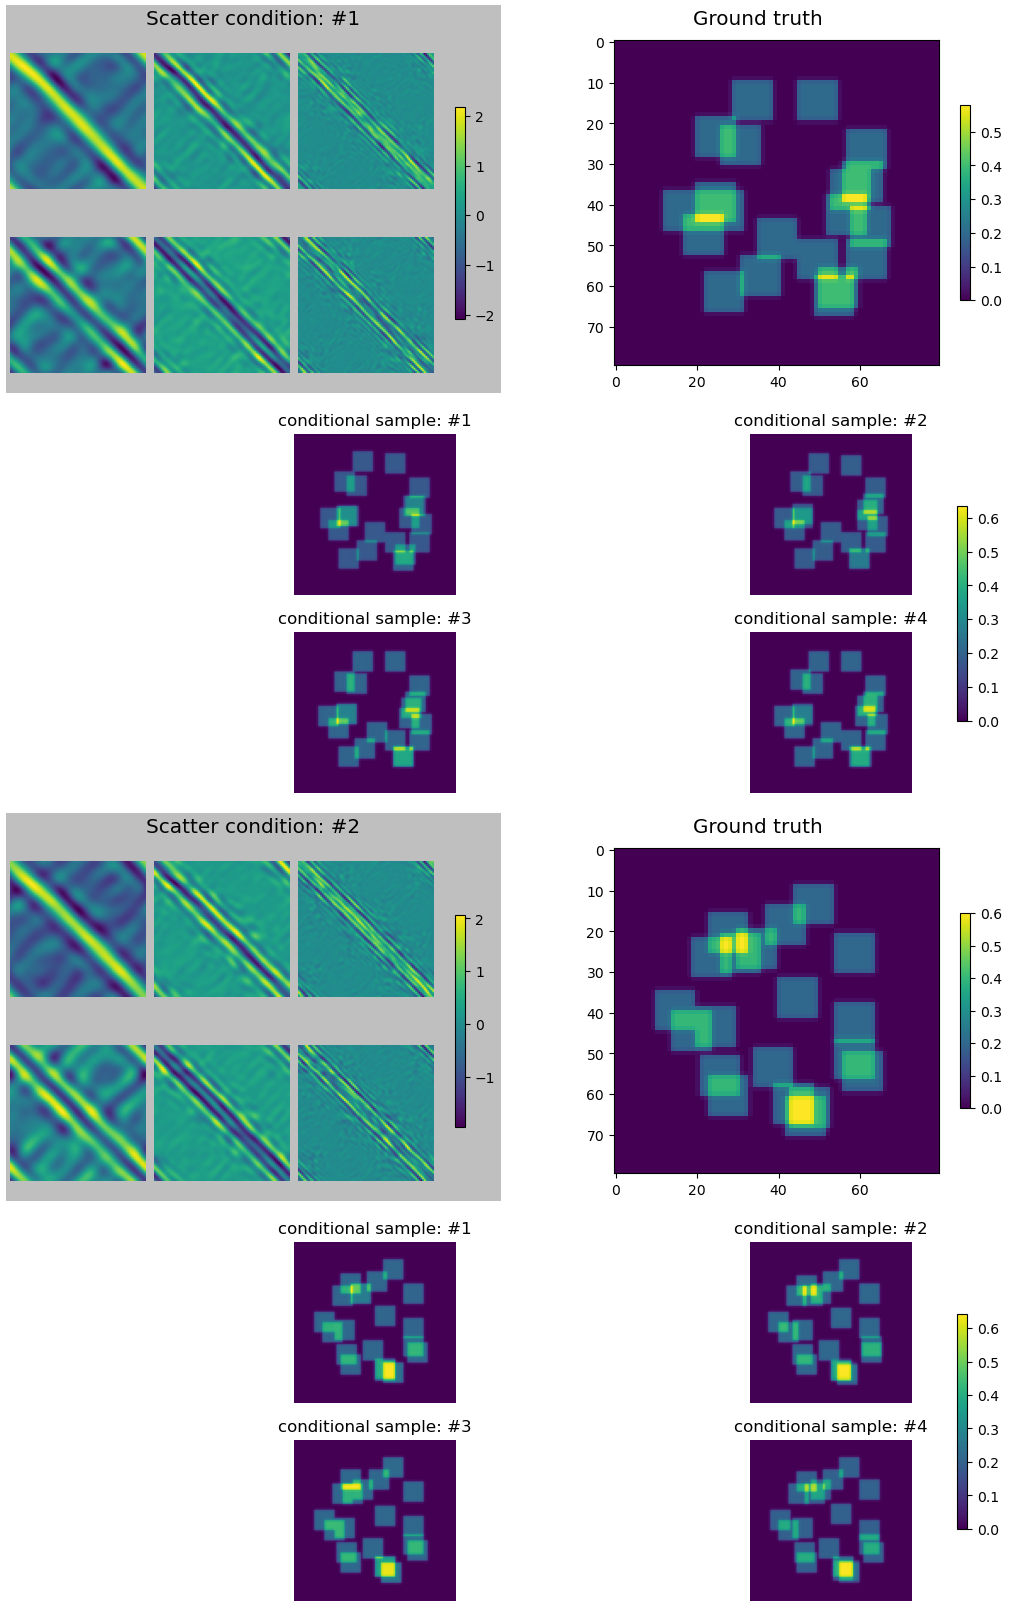

In [36]:
num_samples_per_cond_plot = 4
fig = plt.figure(layout='constrained', figsize=(10, 16))
subfigs = fig.subfigures(2, 1, wspace=0.07)
for i in range(2):
    #subfig = fig.subfigures(layout='constrained', figsize=(10, 4))
    subfigsnest = subfigs[i].subfigures(2, 1)#, wspace=0.1)
    #print(subfigs.shape)
    subfigsnest1 = subfigsnest[0].subfigures(1, 2)#, height_ratios=[1, 1.4])
    axsLeft = subfigsnest1[0].subplots(2,3)
    subfigsnest1[0].set_facecolor('0.75')
    l = 0
    for k in range(3):
        for j in range(2):
            im = axsLeft[j,k].imshow(scatter_test[i, :, :, l])#,vmin=-2.5, vmax=2.5)
            #print(test_batch_cond_denorm[i, :, :, l].shape)
            l += 1
            axsLeft[j,k].axis("off")
    subfigsnest1[0].suptitle(f"Scatter condition: #{i + 1}", fontsize='x-large')
    subfigsnest1[0].colorbar(im,shrink=0.6, ax=axsLeft, location='right')
    
    axsRight = subfigsnest1[1].subplots(1, 1)
    im_eta = axsRight.imshow(eta_re_test[i, :, :, 0])
    
    #subfigs[1].set_facecolor('0.85')
    #subfigs[1].colorbar(pc, shrink=0.6, ax=axsRight)
    subfigsnest1[1].suptitle('Ground truth', fontsize='x-large')
    subfigsnest1[1].colorbar(im_eta,shrink=0.6, ax=axsRight)
    #fig.suptitle('Scatter and ground truth', fontsize='xx-large')
    
    # Plot generated samples.
    ax = subfigsnest[1].subplots(
              2, int(num_samples_per_cond_plot/2))#, figsize=(num_samples_per_cond_plot*2, 4))
    l = 0
    for k in range(2):
        for j in range(int(num_samples_per_cond_plot/2)):
            im = ax[k,j].imshow(
                 cond_samples_denorm_[i, l, :, :, 0])#, vmin=0, vmax=2.5)
            #square = patches.Rectangle(xy=(11, 11), width=7, height=7, fill=False, edgecolor='red')
            ax[k,j].set_title(f"conditional sample: #{l+1}")
            ax[k,j].axis("off")
            l += 1
    subfigsnest[1].colorbar(im, ax=ax[:,:], shrink=0.6, location="right")
        
    #plt.tight_layout()
#fig.savefig('cond_smooth_sigma_0.04_freq_2.5.png')
plt.show()

### Writing files for results

In [37]:
with h5py.File("results_diffusion_widebnet_squares_freq_2.5_5_10.hdf5", "w") as f:
    #Lambda = f.create_dataset('Lambda', data=test_batch_cond_denorm)
    eta = f.create_dataset('eta', data=eta_re_test)
    eta_predicted = f.create_dataset('eta_pred', data=cond_samples_denorm_)